In [122]:
 !pip install tensorflow==2.11.0 opencv-python

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array


2025-08-18 00:48:29.106410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#import dependecies 
import cv2 
import os 
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
#import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [5]:
#prevent OOM errors by setting gpu memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
# #set paths
# POS_PATH = os.path.join('data', 'positive')
# NEG_PATH = os.path.join('data', 'negative')
# ANC_PATH = os.path.join('data', 'anchor')

In [7]:
# #move all the lfw folder to the repositories 
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.makedirs(NEG_PATH, exist_ok=True)
#         os.replace(EX_PATH, NEW_PATH)
        


In [8]:
#import uuid library to generateunique image names
import uuid

In [9]:
# Define your directories
POS_PATH = 'data/positive'
ANC_PATH = 'data/anchor'
NEG_PATH = 'data/negative'
# Make sure directories exist
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)

# Start webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)

    # Resize frame for faster saving
    small_frame = cv2.resize(frame, (320, 240))

    # Show the frame on the screen
    cv2.imshow('Image Collection', small_frame)

    key = cv2.waitKey(1) & 0xFF

    # Save positive image
    if key == ord('p'):
        imgname = os.path.join(POS_PATH, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(imgname, small_frame)
        print(f"[INFO] Saved POS image: {imgname}")

    # Save anchor image
    elif key == ord('a'):
        imgname = os.path.join(ANC_PATH, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(imgname, small_frame)
        print(f"[INFO] Saved ANC image: {imgname}")

    # Quit
    elif key == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

2025-08-18 00:48:51.625 Python[3145:116726] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


-1

In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

2025-08-18 00:48:55.493927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# def preprocess(file_path):
#     byte_img = tf.io.read_file(file_path)
    
#     # Try JPEG decode first
#     try:
#         img = tf.io.decode_jpeg(byte_img, channels=3)
#     except tf.errors.InvalidArgumentError:
#         # Try PNG as fallback
#         try:
#             img = tf.io.decode_png(byte_img, channels=3)
#         except tf.errors.InvalidArgumentError:
#             print(f"⚠️ Skipping invalid image file: {file_path}")
#             return None  # You may choose to raise or return a dummy tensor here

#     img = tf.image.resize(img, (100, 100))
#     img = img / 255.0
#     return img


In [12]:
def preprocess(file_path):
    #read in image from filepath
    byte_img = tf.io.read_file(file_path)
    #load in image using tensorflow
    img = tf.io.decode_jpeg(byte_img)
    #preprocessing the image
    img =tf.image.resize(img, (100,100))
    #scale image to be between 0 and 1 
    img = img / 255.0
    return img

In [13]:
#labelling when the data should pass through the anchor and positive or negative
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [14]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [15]:
 samples = data.as_numpy_iterator()

In [16]:
example = samples.next()

In [17]:
example

(b'data/anchor/23a85db6-357b-11f0-954e-acde48001122.jpg',
 b'data/positive/81ad398c-357a-11f0-954e-acde48001122.jpg',
 1.0)

In [18]:
res = preprocess_twin(*example)

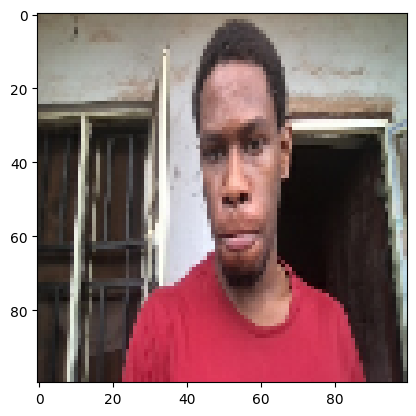

In [19]:
plt.imshow(res[0])

In [20]:
#Build a dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [21]:
round(len(data)*.7)

420

In [22]:
#Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [23]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [24]:
#Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [25]:
inp = Input(shape=(100,100,3), name='input_image')

In [26]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [27]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [28]:
def make_embedding_model():
    input = Input(shape=(100, 100, 3))  # same as your image shape

    x = Conv2D(64, (10, 10), activation='relu')(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (7, 7), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (4, 4), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (4, 4), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(4096, activation='sigmoid')(x)  # final feature embedding

    model = Model(inputs=input, outputs=x, name='EmbeddingModel')
    return model

    return Model(inputs=[inp], outputs=[d1], name='embedding')

# ✅ Now call the function to create the model
embedding = make_embedding_model()
embedding.summary()

Model: "EmbeddingModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 39, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)    

In [29]:
input_anchor = Input(shape=(100, 100, 3), name='anchor_input')
input_positive = Input(shape=(100, 100, 3), name='positive_input')
input_negative = Input(shape=(100, 100, 3), name='negative_input')

embedding_anchor = embedding(input_anchor)
embedding_positive = embedding(input_positive)
embedding_negative = embedding(input_negative)

output = tf.stack([embedding_anchor, embedding_positive, embedding_negative], axis=1)


siamese_model = Model(
    inputs=[input_anchor, input_positive, input_negative],
    outputs=[embedding_anchor, embedding_positive, embedding_negative]
)



In [30]:
#siamese L1 distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    #this tells the model what to do it when data passes through it calls to self
    def call(self, input_embedding, validation_embedding):
        #this retuns an absolute value when subtracting theanchor vlaue from either the pos or neg
        return tf.math.abs(input_embedding - validation_embedding)

In [31]:
# Define triplet loss
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + margin
        return tf.reduce_mean(tf.maximum(basic_loss, 0.0))
    return loss

# Compile the model
siamese_model.compile(optimizer='adam', loss=triplet_loss(margin=1.0))


In [32]:
l1 = L1Dist()

In [33]:
# l1(anchor_embedding, validation_embedding)

In [34]:
# def make_siamese_model():

#     #handle inputs
#     #Anchor image input in the network
#     input_image = Input(name='input_img', shape=(100,100,3))

#     #validation image in the network
#     validation_image = Input(name='validation_img', shape=(100,100,3))

#     #combine siamese distance components
#     siamese_layer = L1Dist()
#     siamese_layer._name = 'distance'
#     distances = siamese_layer(embedding(input_image), embedding(validation_image))

#     #classifier layer 
#     classifier = Dense(1, activation='sigmoid')(distances)

#     return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    
# siamese_model = make_siamese_model()
# siamese_model.summary()

In [35]:
def build_embedding_model():
    inputs = tf.keras.layers.Input(shape=(100, 100, 3))

    # Simple CNN for feature extraction
    x = tf.keras.layers.Conv2D(64, (10,10), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)
    
    x = tf.keras.layers.Conv2D(128, (7,7), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(128, (4,4), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(256, (4,4), activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096, activation='sigmoid')(x)

    return tf.keras.Model(inputs, x)
    
embedding_model = build_embedding_model()


In [36]:
def make_siamese_model():
    input_shape = (100, 100, 3)

    anchor_input = tf.keras.layers.Input(name='anchor', shape=input_shape)
    positive_input = tf.keras.layers.Input(name='positive', shape=input_shape)
    negative_input = tf.keras.layers.Input(name='negative', shape=input_shape)

    # Use the same CNN for all 3 branches
    embedding_network = build_embedding_model()  # Define this model separately

    encoded_anchor = embedding_network(anchor_input)
    encoded_positive = embedding_network(positive_input)
    encoded_negative = embedding_network(negative_input)

    # Outputs as a tuple
    outputs = tf.stack([encoded_anchor, encoded_positive, encoded_negative], axis=1)

    model = tf.keras.Model(inputs=[anchor_input, positive_input, negative_input], outputs=outputs)
    return model
    
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                          

In [37]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [38]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [39]:
siamese_layer = L1Dist()

In [40]:
distances = siamese_layer(inp_embedding, val_embedding)

In [41]:
#setting up the loss function 
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [42]:
#setting up optimzer
opt = tf.keras.optimizers.Adam(1e-4)

In [43]:
#establish checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [44]:
test_batch = train_data.as_numpy_iterator()

In [45]:
batch_1 = test_batch.next()

In [46]:
x = batch_1[:2]

In [47]:
y = batch_1[2]

In [48]:
y

array([1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.],
      dtype=float32)

In [49]:
import tensorflow as tf
import os
import numpy as np

# Paths
ANC_PATH = 'data/anchor'
POS_PATH = 'data/positive'
NEG_PATH = 'data/negative'

IMG_HEIGHT = 100
IMG_WIDTH = 100

def preprocess_image(file_path):
    # Load image, decode, resize, normalize
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = image / 255.0
    return image

def get_image_paths(folder):
    return [os.path.join(folder, fname) for fname in os.listdir(folder) if fname.endswith('.jpg')]

# Get file paths
anchor_paths = get_image_paths(ANC_PATH)
positive_paths = get_image_paths(POS_PATH)
negative_paths = get_image_paths(NEG_PATH)

# Convert to datasets of actual image tensors
anchor_ds = tf.data.Dataset.from_tensor_slices(anchor_paths).map(preprocess_image)
positive_ds = tf.data.Dataset.from_tensor_slices(positive_paths).map(preprocess_image)
negative_ds = tf.data.Dataset.from_tensor_slices(negative_paths).map(preprocess_image)

# Zip into triplets
train_data = tf.data.Dataset.zip((anchor_ds, positive_ds, negative_ds))
train_data = train_data.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)


In [50]:
@tf.function
def train_step(batch):
    anchor, positive, negative = batch
# ✅ unpack your batch

    with tf.GradientTape() as tape:
        # ✅ Feed inputs as a list
        embeddings = siamese_model([anchor, positive, negative], training=True)
        loss = triplet_loss_fn(None, embeddings)  # y_true is not used in triplet loss

    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, siamese_model.trainable_variables))

    return loss


In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image

# Create an ImageDataGenerator for augmentation
augment = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Function to apply augmentation to a single image
def apply_augmentation(img):
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    augmented_img = augment.flow(img, batch_size=1).next()[0]
    return augmented_img


In [52]:
def create_triplets(images, labels):
    anchor, positive, negative = [], [], []
    label_to_indices = {label: np.where(labels == label)[0] for label in np.unique(labels)}
    
    for idx in range(len(images)):
        current_img = images[idx]
        current_label = labels[idx]
        
        # Choose a positive example (same label)
        pos_idx = idx
        while pos_idx == idx:
            pos_idx = np.random.choice(label_to_indices[current_label])
        
        # Choose a negative example (different label)
        neg_label = np.random.choice([l for l in label_to_indices if l != current_label])
        neg_idx = np.random.choice(label_to_indices[neg_label])
        
        anchor.append(current_img)
        positive.append(images[pos_idx])
        negative.append(images[neg_idx])
    
    return np.array(anchor), np.array(positive), np.array(negative)


In [53]:
def generate_triplets(anchor_folder, positive_folder, negative_folder):
    triplets = []
    for anchor_filename in os.listdir(anchor_folder):
        # Select matching positive and random negative
        positive_filename = anchor_filename  # assuming same name exists
        negative_filename = random.choice(os.listdir(negative_folder))

        # Load and preprocess images
        anchor_img = preprocess(os.path.join(anchor_folder, anchor_filename))
        positive_img = preprocess(os.path.join(positive_folder, positive_filename))
        negative_img = preprocess(os.path.join(negative_folder, negative_filename))

        # Augment each image
        anchor_img = apply_augmentation(anchor_img)
        positive_img = apply_augmentation(positive_img)
        negative_img = apply_augmentation(negative_img)

        # Store the triplet
        triplets.append((anchor_img, positive_img, negative_img))

    return triplets


In [54]:
def load_images_from_folder(folder, size=(100, 100)):
    images = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        if os.path.isfile(path):
            img = cv2.imread(path)
            if img is not None:
                img = cv2.resize(img, size)
                img = img / 255.0  # Normalize
                images.append(img)
    return np.array(images)


In [55]:
anchor_images = load_images_from_folder(ANC_PATH)
positive_images = load_images_from_folder(POS_PATH)
negative_images = load_images_from_folder(NEG_PATH)


In [56]:
num_triplets = min(len(anchor_images), len(positive_images), len(negative_images))

anchor_images = anchor_images[:num_triplets]
positive_images = positive_images[:num_triplets]
negative_images = negative_images[:num_triplets]


In [57]:
BATCH_SIZE = 16  # or 32

dataset = tf.data.Dataset.from_tensor_slices((anchor_images, positive_images, negative_images))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [58]:
optimizer = tf.keras.optimizers.Adam()
triplet_loss_fn = triplet_loss(margin=1.0)


In [59]:
import tensorflow as tf

# Step 1: Embedding model
def build_embedding_model():
    inputs = tf.keras.layers.Input(shape=(100, 100, 3))

    x = tf.keras.layers.Conv2D(64, (10,10), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(128, (7,7), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(128, (4,4), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(256, (4,4), activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096, activation='sigmoid')(x)

    return tf.keras.Model(inputs, x)

# Step 2: Triplet Loss Function
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + margin
        loss_val = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
        return loss_val
    return loss


# Step 3: Siamese Model with 3 inputs
def make_siamese_model():
    input_shape = (100, 100, 3)

    anchor_input = tf.keras.layers.Input(name='anchor', shape=input_shape)
    positive_input = tf.keras.layers.Input(name='positive', shape=input_shape)
    negative_input = tf.keras.layers.Input(name='negative', shape=input_shape)

    embedding_network = build_embedding_model()

    encoded_anchor = embedding_network(anchor_input)
    encoded_positive = embedding_network(positive_input)
    encoded_negative = embedding_network(negative_input)

    # Concatenate embeddings into a single tensor of shape (batch_size, 3, 4096)
    merged_output = tf.stack([encoded_anchor, encoded_positive, encoded_negative], axis=1)

    model = tf.keras.Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=merged_output
    )
    return model

# Step 4: Create and compile the model
siamese_model = make_siamese_model()
siamese_model.compile(optimizer='adam', loss=triplet_loss(margin=1.0))
siamese_model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                          

In [60]:
def triplet_generator():
    while True:
        yield ([anchor, positive, negative], dummy_label)

dataset = tf.data.Dataset.from_generator(triplet_generator, output_signature=(
    (tf.TensorSpec(shape=(100, 100, 3), dtype=tf.float32),
     tf.TensorSpec(shape=(100, 100, 3), dtype=tf.float32),
     tf.TensorSpec(shape=(100, 100, 3), dtype=tf.float32)),
    tf.TensorSpec(shape=(), dtype=tf.float32)
)).batch(32)


In [61]:
#calculating the loss
#tf.losses.BinaryCrossentropy??

In [62]:
# def train(data, EPOCHS):
#     #loop through the epochs
#     for epoch in range(1, EPOCHS+1):
#         print('\n Epoch {}/{}'.format(epoch, EPOCHS))
#         progbar = tf.keras.utils.Progbar(len(data))

#         #Loop through each batch
#         for idx, batch in enumerate(data):
#             #Run train step here 
#             train_step(batch)
#             progbar.update(idx+1)

#         #save checkpoints
#         if epoch % 10 == 0:
#             checkpoint.save(file_prefix=checkpoint_prefix)

In [63]:
def train(data, EPOCHS):
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        progbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            progbar.update(idx + 1, [('loss', float(loss))])


In [64]:
# import shutil
# shutil.rmtree("checkpoints", ignore_errors=True)


In [65]:
EPOCHS = 50

In [136]:
train(train_data, EPOCHS)


Epoch 1/50
11/11 [==============================] - 167s 15s/step - loss: 0.1801

Epoch 2/50
11/11 [==============================] - 138s 12s/step - loss: 0.1300

Epoch 3/50
11/11 [==============================] - 154s 14s/step - loss: 0.2108

Epoch 4/50
11/11 [==============================] - 152s 14s/step - loss: 0.0613

Epoch 5/50
11/11 [==============================] - 144s 13s/step - loss: 0.0000e+00

Epoch 6/50
11/11 [==============================] - 137s 12s/step - loss: 0.0000e+00

Epoch 7/50
11/11 [==============================] - 126s 11s/step - loss: 0.0040

Epoch 8/50
11/11 [==============================] - 102s 9s/step - loss: 0.0333

Epoch 9/50
11/11 [==============================] - 104s 9s/step - loss: 0.2090

Epoch 10/50
11/11 [==============================] - 129s 11s/step - loss: 0.2027

Epoch 11/50
11/11 [==============================] - 101s 9s/step - loss: 0.4438

Epoch 12/50
11/11 [==============================] - 131s 12s/step - loss: 0.2668

Epoch 1

In [66]:
def is_same_person(img1, img2, threshold=0.5):
    emb1 = siamese_model.get_layer('model').predict(tf.expand_dims(img1, axis=0))
    emb2 = siamese_model.get_layer('model').predict(tf.expand_dims(img2, axis=0))
    distance = tf.norm(emb1 - emb2)
    return distance.numpy(), distance < threshold


In [67]:
#import calculation metrics 
from tensorflow.keras.metrics import Precision, Recall

In [68]:
anchor_input, positive_input, negative_input = test_data.as_numpy_iterator().next()

In [69]:
for item in test_data.take(1):
    print(item)


(<tf.Tensor: shape=(16, 100, 100, 3), dtype=float32, numpy=
array([[[[0.44835296, 0.40874508, 0.31266665],
         [0.4674902 , 0.43611765, 0.36160785],
         [0.48215684, 0.4507843 , 0.3645098 ],
         ...,
         [0.47843137, 0.4745098 , 0.40392157],
         [0.4745098 , 0.47058824, 0.4       ],
         [0.48380393, 0.47988236, 0.40929413]],

        [[0.44      , 0.40039214, 0.30431372],
         [0.4504706 , 0.41792157, 0.3438039 ],
         [0.48000002, 0.44745097, 0.36156863],
         ...,
         [0.4809804 , 0.48490196, 0.41431373],
         [0.4856079 , 0.48952946, 0.4189412 ],
         [0.4838824 , 0.48780397, 0.41721573]],

        [[0.45137253, 0.40823528, 0.3227451 ],
         [0.47568628, 0.43254903, 0.3619608 ],
         [0.4627451 , 0.41960785, 0.34117648],
         ...,
         [0.5       , 0.50392157, 0.4372549 ],
         [0.5084314 , 0.51235294, 0.44176468],
         [0.50392157, 0.50784314, 0.4372549 ]],

        ...,

        [[0.22392157, 0.18784314

In [70]:
#make predictions
def preprocess_triplet(anchor, positive, negative):
    # Example: normalize images between 0 and 1 (if not already done)
    anchor = anchor / 255.0
    positive = positive / 255.0
    negative = negative / 255.0
    return (anchor, positive, negative)


In [71]:
test_data = test_data.map(preprocess_triplet)


In [72]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img


In [73]:
print(os.listdir('data/negative'))


['Gerry_Kelly_0001.jpg', 'Tom_Hanks_0009.jpg', 'Hugh_Carey_0001.jpg', 'Priscilla_Owen_0002.jpg', 'Robert_Mueller_0002.jpg', 'Georgia_Giddings_0001.jpg', 'Helen_Clark_0002.jpg', 'Paul_Byrd_0001.jpg', 'Spencer_Abraham_0009.jpg', 'Sarah_Jessica_Parker_0004.jpg', 'Teresa_Graves_0001.jpg', 'Anja_Paerson_0001.jpg', 'Scott_Hubbard_0001.jpg', 'Mike_Babcock_0001.jpg', 'Tatiana_Shchegoleva_0001.jpg', 'Jacques_Rogge_0008.jpg', 'Ali_Ahmeti_0001.jpg', 'Holly_Hunter_0003.jpg', 'Bill_Callahan_0001.jpg', 'Edgar_Savisaar_0001.jpg', 'Peter_Medgyessy_0001.jpg', 'Kimberly_Stewart_0001.jpg', 'John_Burnett_0001.jpg', 'Naoto_Kan_0003.jpg', 'Heidi_Fleiss_0002.jpg', 'Bill_Frist_0008.jpg', 'Ms_Dynamite_0001.jpg', 'Jeong_Se-hyun_0009.jpg', 'Rick_Wagoner_0001.jpg', 'Kurt_Busch_0002.jpg', 'Zhang_Ziyi_0004.jpg', 'Elizabeth_Hurley_0001.jpg', 'Bronson_Arroyo_0001.jpg', 'Justin_Timberlake_0004.jpg', 'Pat_Burns_0002.jpg', 'Harbhajan_Singh_0001.jpg', 'Bill_Sizemore_0001.jpg', 'Alvaro_Uribe_0022.jpg', 'Stacy_Dragila_0002

In [74]:
negative_img = preprocess('data/negative/Benazir_Bhutto_0003.jpg')  # <- Replace with real name
negative_img = np.expand_dims(negative_img, axis=0)


In [75]:
print("Negative shape:", negative_img.shape)


Negative shape: (1, 100, 100, 3)


In [76]:
def preprocess_triplet(anchor_path, positive_path, negative_path):
    def load_image(path):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [100, 100])
        image = tf.cast(image, tf.float32) / 255.0
        return image

    anchor   = load_image(anchor_path)
    positive = load_image(positive_path)
    negative = load_image(negative_path)

    return (anchor, positive, negative)


In [77]:
min_len = min(len(anchor_paths), len(positive_paths), len(negative_paths))

anchor_paths   = anchor_paths[:min_len]
positive_paths = positive_paths[:min_len]
negative_paths = negative_paths[:min_len]


In [78]:
print(len(anchor_paths), len(positive_paths), len(negative_paths))
# Should print: 347 347 347


347 347 347


In [79]:
dataset = tf.data.Dataset.from_tensor_slices((anchor_paths, positive_paths, negative_paths))
dataset = dataset.map(preprocess_triplet)
dataset = dataset.batch(16)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [80]:
dataset = tf.data.Dataset.from_tensor_slices((anchor_paths, positive_paths, negative_paths))
dataset = dataset.map(preprocess_triplet)
dataset = dataset.batch(16)

# Get a full batch
anchor_img, positive_img, negative_img = dataset.as_numpy_iterator().next()


In [81]:
# Make prediction
result = siamese_model.predict([anchor_img, positive_img, negative_img])

# Forcefully convert to scalar
score = float(result.flatten()[0])  # flatten() makes it 1D, index gets the scalar

# Binary threshold
prediction = 1 if score > 0.5 else 0

# Output
print("Similarity Score:", score)
print("Prediction (1 = same person, 0 = different):", prediction)


1/1 [==============================] - 1s 1s/step
Similarity Score: 0.5039371848106384
Prediction (1 = same person, 0 = different): 1


In [82]:
#post processing the result

# Get the embeddings
anchor_embedding = result[0][0]
positive_embedding = result[0][1]
negative_embedding = result[0][2]

# Calculate Euclidean distances
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

dist_ap = euclidean_distance(anchor_embedding, positive_embedding)
dist_an = euclidean_distance(anchor_embedding, negative_embedding)

# Predict: 1 = same person, 0 = different
prediction = 1 if dist_ap < dist_an else 0

# Print results
print(f"Distance (Anchor-Positive): {dist_ap:.4f}")
print(f"Distance (Anchor-Negative): {dist_an:.4f}")
print("Prediction (1 = same person, 0 = different):", prediction)


Distance (Anchor-Positive): 0.1539
Distance (Anchor-Negative): 0.2800
Prediction (1 = same person, 0 = different): 1


In [83]:
#post processing the result
# res = []
# for prediction in y_hat:
#     if prediction > 0.5:
#         res.append(1)
#     else:
#         res.append(0)

In [84]:
for example in test_data.take(1):
    print(type(example))
    print(example)


<class 'tuple'>
(<tf.Tensor: shape=(16, 100, 100, 3), dtype=float32, numpy=
array([[[[0.00160338, 0.00148035, 0.0011574 ],
         [0.00170581, 0.00158278, 0.00125982],
         [0.00182545, 0.00170242, 0.00137947],
         ...,
         [0.00208228, 0.0020669 , 0.00175932],
         [0.00209304, 0.00207766, 0.00177009],
         [0.00212734, 0.00211196, 0.00180438]],

        [[0.00162661, 0.00150358, 0.00118062],
         [0.00175102, 0.00162799, 0.00130504],
         [0.00169704, 0.00157401, 0.00125106],
         ...,
         [0.0021461 , 0.00213533, 0.00182622],
         [0.00216993, 0.00215917, 0.00185006],
         [0.00217932, 0.00216855, 0.00185944]],

        [[0.00181469, 0.00169166, 0.0013687 ],
         [0.00184006, 0.00173241, 0.00140177],
         [0.00185313, 0.00174548, 0.00141484],
         ...,
         [0.00220684, 0.0022376 , 0.00191465],
         [0.0022376 , 0.00226836, 0.00194541],
         [0.00218608, 0.00220992, 0.00190773]],

        ...,

        [[0.0008

In [85]:
print(negative_paths[:5])  # Show first 5 items
print(type(negative_paths[0]))  # Check the data type of the first item


['data/negative/Gerry_Kelly_0001.jpg', 'data/negative/Tom_Hanks_0009.jpg', 'data/negative/Hugh_Carey_0001.jpg', 'data/negative/Priscilla_Owen_0002.jpg', 'data/negative/Robert_Mueller_0002.jpg']
<class 'str'>


In [86]:
import glob

anchor_paths = sorted(glob.glob("data/anchor/*.jpg"))
positive_paths = sorted(glob.glob("data/positive/*.jpg"))
negative_paths = sorted(glob.glob("data/negative/*.jpg"))


In [87]:
min_len = min(len(anchor_paths), len(positive_paths), len(negative_paths))

anchor_paths = anchor_paths[:min_len]
positive_paths = positive_paths[:min_len]
negative_paths = negative_paths[:min_len]


In [88]:
print("Anchor:", len(anchor_paths))
print("Positive:", len(positive_paths))
print("Negative:", len(negative_paths))


Anchor: 347
Positive: 347
Negative: 347


In [89]:
print("Anchor paths:", anchor_paths[:5])
print("Positive paths:", positive_paths[:5])
print("Negative paths:", negative_paths[:5])


Anchor paths: ['data/anchor/007a6000-357b-11f0-954e-acde48001122.jpg', 'data/anchor/00a994d8-357b-11f0-954e-acde48001122.jpg', 'data/anchor/01222268-357b-11f0-954e-acde48001122.jpg', 'data/anchor/01e003f0-357b-11f0-954e-acde48001122.jpg', 'data/anchor/0219f150-357b-11f0-954e-acde48001122.jpg']
Positive paths: ['data/positive/4bcb8ec2-357a-11f0-954e-acde48001122.jpg', 'data/positive/4c08f4f6-357a-11f0-954e-acde48001122.jpg', 'data/positive/4ca5a882-357a-11f0-954e-acde48001122.jpg', 'data/positive/4d879f58-357a-11f0-954e-acde48001122.jpg', 'data/positive/4dfb77a2-357a-11f0-954e-acde48001122.jpg']
Negative paths: ['data/negative/Abdullah_al-Attiyah_0002.jpg', 'data/negative/Abdullah_al-Attiyah_0003.jpg', 'data/negative/Adam_Sandler_0001.jpg', 'data/negative/Adam_Sandler_0002.jpg', 'data/negative/Adam_Sandler_0003.jpg']


In [90]:
# Build the dataset
dataset = tf.data.Dataset.from_tensor_slices((anchor_paths, positive_paths, negative_paths))
dataset = dataset.map(preprocess_triplet)  # <- make sure this function loads and preprocesses images
dataset = dataset.batch(16)

In [91]:
for triplet in dataset.take(1):
    print(triplet[0].shape)  # anchor
    print(triplet[1].shape)  # positive
    print(triplet[2].shape)  # negative


(16, 100, 100, 3)
(16, 100, 100, 3)
(16, 100, 100, 3)


In [92]:
def load_and_preprocess(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (100, 100))
    image = image / 255.0
    return image

def preprocess_triplet(anchor_path, positive_path, negative_path):
    return (
        load_and_preprocess(anchor_path),
        load_and_preprocess(positive_path),
        load_and_preprocess(negative_path)
    )

dataset = tf.data.Dataset.from_tensor_slices((anchor_paths, positive_paths, negative_paths))
dataset = dataset.map(preprocess_triplet)
dataset = dataset.batch(16)


In [97]:
# Take a batch from dataset
anchor_batch, positive_batch, negative_batch = next(iter(dataset))

# Now anchor_batch.shape should be (batch_size, height, width, channels)

# Run prediction
y_hat = model.predict([anchor_batch, positive_batch, negative_batch])


1/1 [==============================] - 1s 1s/step


In [98]:
print(anchor_batch.shape)   # (16, 100, 100, 3)
print(positive_batch.shape) # (16, 100, 100, 3)
print(negative_batch.shape) # (16, 100, 100, 3)


(16, 100, 100, 3)
(16, 100, 100, 3)
(16, 100, 100, 3)


In [99]:

# Get distance scores (simplified — you may use L2 or cosine in your loss)
# Let's pretend y_hat[:, 0, :] is anchor, y_hat[:, 1, :] is positive, y_hat[:, 2, :] is negative
anchor = y_hat[:, 0, :]
positive = y_hat[:, 1, :]
negative = y_hat[:, 2, :]

# Compute distances
pos_dist = np.linalg.norm(anchor - positive, axis=1)
neg_dist = np.linalg.norm(anchor - negative, axis=1)

# Generate predictions based on threshold (smaller distance => same person)
y_pred = np.where(pos_dist < neg_dist, 1, 0)


In [100]:
# Ground truth: In triplet setup, 1 = positive pair is more similar than negative
y_true = np.ones_like(y_pred)


In [101]:
from tensorflow.keras.metrics import Recall

# Create metric object
recall = Recall()

# Update state
recall.update_state(y_true, y_pred)

# Output Recall value
print("Recall:", recall.result().numpy())


Recall: 1.0


In [102]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

def CNN_model(input_layer):
    x = Conv2D(64, (3,3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(128)(x)  # 128-dimensional embedding output

    return output


In [103]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Define the input
input = Input(shape=(100, 100, 3))

# Build the embedding model using your existing CNN_model
embedding = CNN_model(input)
embedding_model = Model(inputs=input, outputs=embedding)


In [104]:
print("Anchor shape:", anchor.shape)
print("Positive shape:", positive.shape)
print("Negative shape:", negative.shape)


Anchor shape: (16, 4096)
Positive shape: (16, 4096)
Negative shape: (16, 4096)


In [105]:
import numpy as np

def compute_similarity(emb1, emb2):
    return np.linalg.norm(emb1 - emb2, axis=1)


In [106]:
# These are already embeddings
anchor_embeds = anchor
positive_embeds = positive
negative_embeds = negative

# Compute distances
ap_distance = compute_similarity(anchor_embeds, positive_embeds)
an_distance = compute_similarity(anchor_embeds, negative_embeds)

# Predict matches (1 = match, 0 = not match)
y_hat = (ap_distance < an_distance).astype(int)

# Assuming all pairs are anchor-positive = match
y_true = np.ones(len(y_hat))

# Precision
from tensorflow.keras.metrics import Precision

p = Precision()
p.update_state(y_true, y_hat)
print("Precision:", p.result().numpy())


Precision: 1.0


In [107]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Example: anchor_embeds, positive_embeds, negative_embeds are already computed embeddings
# ap_distance = distance(anchor, positive)
# an_distance = distance(anchor, negative)

# Compute distances
ap_distance = compute_similarity(anchor_embeds, positive_embeds)  # smaller = more similar
an_distance = compute_similarity(anchor_embeds, negative_embeds)

# Create labels
# 1 = match (anchor-positive), 0 = non-match (anchor-negative)
y_true = np.concatenate([
    np.ones(len(ap_distance)),   # all anchor-positive are true matches
    np.zeros(len(an_distance))   # all anchor-negative are true non-matches
])

# Predictions
# Match if distance < threshold — here we use anchor-positive for pos set and anchor-negative for neg set
y_pred_pos = (ap_distance < an_distance).astype(int)  # for positive set
y_pred_neg = (an_distance < ap_distance).astype(int)  # for negative set
y_pred = np.concatenate([y_pred_pos, y_pred_neg])

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")


Confusion Matrix:
 [[16  0]
 [ 0 16]]
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


In [128]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Positive and negative distances
ap_distance = compute_similarity(anchor_embeds, positive_embeds)  # smaller = more similar
an_distance = compute_similarity(anchor_embeds, negative_embeds)

# Labels: 1 for match (anchor-positive), 0 for non-match (anchor-negative)
distances = np.concatenate([ap_distance, an_distance])
labels = np.concatenate([
    np.ones(len(ap_distance)), 
    np.zeros(len(an_distance))
])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(distances, labels, test_size=0.3, random_state=42)

# Choose a threshold — here we use the median distance from the training set
threshold = np.median(X_train[y_train == 1])  # threshold based on positives in train

# Predictions on test set
y_pred = (X_test < threshold).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Results
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"Threshold used: {threshold:.4f}")


Confusion Matrix:
 [[5 0]
 [1 4]]
Accuracy: 0.90
Precision: 1.00
Recall: 0.80
Threshold used: 0.9979


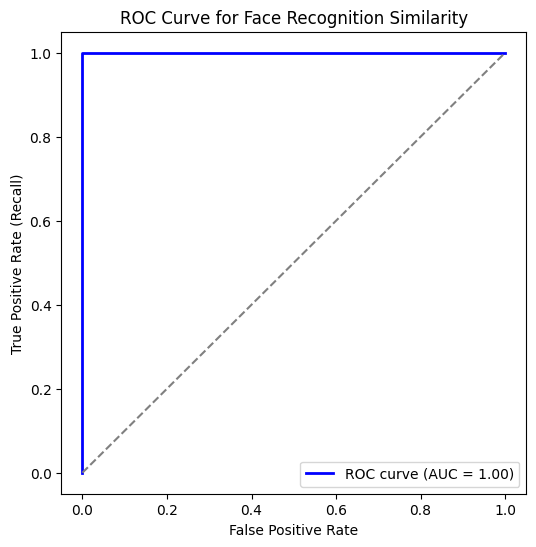

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Positive and negative distances
ap_distance = compute_similarity(anchor_embeds, positive_embeds)  # smaller = more similar
an_distance = compute_similarity(anchor_embeds, negative_embeds)

# Labels: 1 = match, 0 = non-match
distances = np.concatenate([ap_distance, an_distance])
labels = np.concatenate([
    np.ones(len(ap_distance)), 
    np.zeros(len(an_distance))
])

# IMPORTANT: ROC expects "higher = more positive".
# But in your case, smaller distance = more positive (match).
# So invert the distance to similarity:
scores = -distances   # flipping sign makes smaller distances = larger scores

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve for Face Recognition Similarity")
plt.legend(loc="lower right")
plt.show()


In [109]:
from torch.utils.data import Dataset
from PIL import Image
import os
import random

class SiameseDataset(Dataset):
    def __init__(self, image_folder_dataset, transform=None):
        self.anchor_dir = os.path.join(image_folder_dataset, "anchor")
        self.positive_dir = os.path.join(image_folder_dataset, "positive")
        self.negative_dir = os.path.join(image_folder_dataset, "negative")
        self.transform = transform

        self.anchor_images = os.listdir(self.anchor_dir)
        self.positive_images = os.listdir(self.positive_dir)
        self.negative_images = os.listdir(self.negative_dir)

    def __getitem__(self, index):
        # Get anchor image
        anchor_img_path = os.path.join(self.anchor_dir, self.anchor_images[index])
        anchor_img = Image.open(anchor_img_path).convert("L")

        # Randomly decide if this is a positive or negative pair
        should_get_same_class = random.randint(0, 1)

        if should_get_same_class:
            # Get positive image
            positive_img_name = random.choice(self.positive_images)
            positive_img_path = os.path.join(self.positive_dir, positive_img_name)
            img_to_compare = Image.open(positive_img_path).convert("L")
            label = 1
        else:
            # Get negative image
            negative_img_name = random.choice(self.negative_images)
            negative_img_path = os.path.join(self.negative_dir, negative_img_name)
            img_to_compare = Image.open(negative_img_path).convert("L")
            label = 0

        if self.transform:
            anchor_img = self.transform(anchor_img)
            img_to_compare = self.transform(img_to_compare)

        return anchor_img, img_to_compare, label

    def __len__(self):
        return len(self.anchor_images)


In [183]:
# !pip install seaborn



Confusion Matrix:
 [[4 1]
 [1 4]]
Accuracy: 0.80
Precision: 0.80
Recall: 0.80


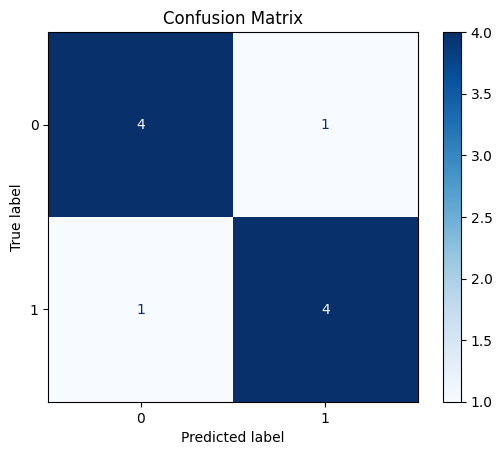

In [110]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example true and predicted labels (replace these with your real data)
y_true = [1, 0, 1, 1, 0, 1, 0, 0, 1, 0]  # Actual labels
y_pred = [1, 0, 1, 0, 0, 1, 0, 1, 1, 0]  # Predicted labels

# Compute metrics
conf_matrix = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

# Print results
print("Confusion Matrix:\n", conf_matrix)
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


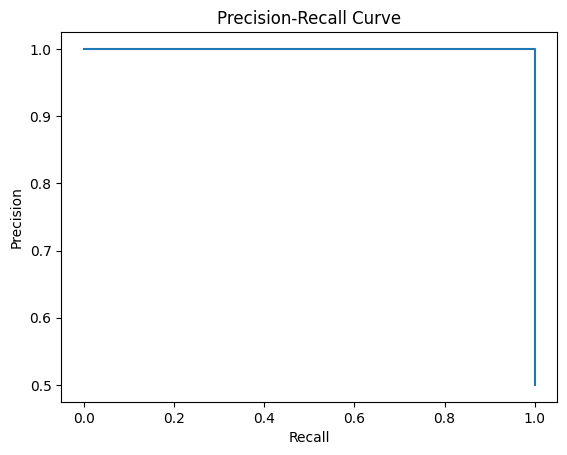

In [113]:
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Example: ground truth labels
y_true = np.array([1, 1, 0, 0, 1, 0])  # same/different

# Example: distances between embeddings
# smaller distance → more similar
distances = np.array([0.2, 0.3, 0.8, 0.9, 0.4, 0.7])

# Convert distances to "similarity scores"
# (invert because higher = more similar)
y_pred_scores = 1 - distances  

# Compute precision-recall
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_scores)

# Plot
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [185]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Set up your image transforms
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Path to your dataset
test_dir = "data"  # assuming you are in the notebook root

# Load your test dataset
test_dataset = SiameseDataset(image_folder_dataset=test_dir, transform=transform)

# Create DataLoader
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1)


In [186]:
# Generate embeddings
# anchor_embeds = embedding_model.predict(anchor)
# positive_embeds = embedding_model.predict(positive)
# negative_embeds = embedding_model.predict(negative)

# # Now define the similarity function
# import numpy as np

# def compute_similarity(a, b):
#     return np.linalg.norm(a - b, axis=1)  # shape: (batch_size,)

# # Compute distances
# ap_distance = compute_similarity(anchor_embeds, positive_embeds)
# an_distance = compute_similarity(anchor_embeds, negative_embeds)

# # Predict matches (1 = match, 0 = not match) using a distance threshold
# threshold = 0.5
# y_hat = ap_distance < an_distance  # True if anchor-positive closer than anchor-negative
# y_hat = y_hat.astype(int)  # Convert boolean to int (1s and 0s)

# # For true labels, assuming 1 = match
# y_true = np.ones(len(y_hat))  # All pairs are expected to be correct (1)

# # Now calculate Precision
# from tensorflow.keras.metrics import Precision

# p = Precision()
# p.update_state(y_true, y_hat)
# print("Precision:", p.result().numpy())


In [187]:
#visualizing result
# Get a batch from your dataset
anchor_batch, positive_batch, negative_batch = next(iter(dataset))

# Use one sample from the batch
test_input = anchor_batch[0]
test_val = positive_batch[0]


In [188]:
# Save
siamese_model.save("siamese_model_tf")

INFO:tensorflow:Assets written to: siamese_model_tf/assets


INFO:tensorflow:Assets written to: siamese_model_tf/assets


In [96]:
#load
model = tf.keras.models.load_model(
    "siamese_model_tf",
    custom_objects={'loss': triplet_loss(margin=1.0)}
)


In [190]:
#make prediction with reloaded model
# model.predict([test_input, test_val])

In [191]:
# Load a batch from your dataset
anchor_batch, positive_batch, negative_batch = next(iter(dataset))

# Select 1 sample from the batch for prediction
anchor = tf.expand_dims(anchor_batch[0], axis=0)     # shape: (1, height, width, channels)
positive = tf.expand_dims(positive_batch[0], axis=0)
negative = tf.expand_dims(negative_batch[0], axis=0)

# Predict using your model
prediction = model.predict([anchor, positive, negative])


1/1 [==============================] - 0s 319ms/step


In [192]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                         

In [193]:
# def verify(embedding_model, detection_threshold, verification_threshold):
#     # Load input image
#     input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))

#     # Initialize list to store results
#     results = []

#     # Loop through all images in the verification folder
#     for image in os.listdir(os.path.join('application_data', 'verification_images')):
#         validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

#         # Generate embeddings
#         input_embed = embedding_model.predict(np.expand_dims(input_img, axis=0))
#         validation_embed = embedding_model.predict(np.expand_dims(validation_img, axis=0))

#         # Compute distance between input and validation image
#         distance = np.linalg.norm(input_embed - validation_embed)

#         # Append result (True if within threshold)
#         results.append(distance < detection_threshold)

#     # Final decision: proportion of matches that exceed verification threshold
#     verified = np.sum(results) / len(results) > verification_threshold
#     return results, verified


In [198]:
# def verify(embedding_model, detection_threshold=0.3, verification_threshold=0.3):
#     results = []
#     input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
#     input_embedding = embedding_model.predict(np.expand_dims(input_img, axis=0))

#     for image in os.listdir('application_data/verification_images'):
#         validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
#         validation_embedding = embedding_model.predict(np.expand_dims(validation_img, axis=0))

#         # Calculate distance
#         distance = np.linalg.norm(input_embedding - validation_embedding)
#         result = distance < verification_threshold
#         results.append(result)

#     verified = np.sum(results) / len(results) > detection_threshold
#     return results, verified 


In [206]:
import os
import numpy as np

def verify(embedding_model, detection_threshold=0.3, verification_threshold=0.3):
    results = []

    # Load and preprocess the input image
    input_img_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
    if not os.path.exists(input_img_path):
        raise FileNotFoundError(f"Input image not found: {input_img_path}")

    input_img = preprocess(input_img_path)
    input_embedding = embedding_model.predict(np.expand_dims(input_img, axis=0))

    # Get verification images
    verification_folder = os.path.join('application_data', 'verification_images')
    verification_images = os.listdir(verification_folder)

    if not verification_images:
        raise ValueError("No images found in verification folder.")

    # Compare with each verification image
    for image_name in verification_images:
        img_path = os.path.join(verification_folder, image_name)
        validation_img = preprocess(img_path)
        validation_embedding = embedding_model.predict(np.expand_dims(validation_img, axis=0))

        # Euclidean distance
        distance = np.linalg.norm(input_embedding - validation_embedding)
        match = distance < verification_threshold
        results.append(match)

    # Determine overall verification
    verified = (np.sum(results) / len(results)) > detection_threshold

    return results, verified


In [199]:
# def verify(model, detection_threshold, verification_threshold):
#     results = []

#     input_img_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
#     input_img = preprocess(input_img_path)

#     verification_dir = os.path.join('application_data', 'verification_images')
#     valid_images = [f for f in os.listdir(verification_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

#     for image in valid_images:
#         try:
#             validation_img = preprocess(os.path.join(verification_dir, image))
#             if validation_img is None:
#                 continue
#             result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
#             results.append(result)
#         except Exception as e:
#             print(f"Skipping {image}: {e}")
#             continue

#     if len(results) == 0:
#         print("No valid images to compare. Verification failed.")
#         return [], False

#     detection = np.sum(np.array(results) > detection_threshold)
#     verification = detection / len(results)
#     verified = verification > verification_threshold

#     return results, verified


In [210]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    small_frame = cv2.resize(frame, (320, 240))

    cv2.imshow('verification', small_frame)

    #verification trigger
    key = cv2.waitKey(10) & 0xFF
    if key == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), small_frame)
        results, verified = verify(embedding_model, 0.5, 0.5)
        print(verified)
    
    elif key == ord('q'):
       break
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(10)

1/1 [==============================] - 0s 47ms/step
False
1/1 [==============================] - 0s 44ms/step
False


-1

In [208]:
np.squeeze(results) > 0.1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [121]:
rm application_data/verification_images/.DS_Store


rm: application_data/verification_images/.DS_Store: No such file or directory


In [322]:
os.listdir(os.path.join('application_data', 'verification_images'))

['2c815212-357b-11f0-954e-acde48001122.jpg',
 '2d5e8af6-357b-11f0-954e-acde48001122.jpg',
 '2baf337c-357b-11f0-954e-acde48001122.jpg',
 '1f07c382-357b-11f0-954e-acde48001122.jpg',
 '0e2b3a94-357b-11f0-954e-acde48001122.jpg',
 '0a79c4f6-357b-11f0-954e-acde48001122.jpg',
 '0b3bf058-357b-11f0-954e-acde48001122.jpg',
 '1fb92e9c-357b-11f0-954e-acde48001122.jpg',
 '2c4c88f2-357b-11f0-954e-acde48001122.jpg',
 '1e18b3b4-357b-11f0-954e-acde48001122.jpg',
 '2be380b4-357b-11f0-954e-acde48001122.jpg',
 '1eccfefa-357b-11f0-954e-acde48001122.jpg',
 '0fe9f5dc-357b-11f0-954e-acde48001122.jpg',
 '0c38611c-357b-11f0-954e-acde48001122.jpg',
 '0ee8b18c-357b-11f0-954e-acde48001122.jpg',
 '1fe28ca6-357b-11f0-954e-acde48001122.jpg',
 '0fa89628-357b-11f0-954e-acde48001122.jpg',
 '1f456dd6-357b-11f0-954e-acde48001122.jpg',
 '1e5d816a-357b-11f0-954e-acde48001122.jpg',
 '1f835f38-357b-11f0-954e-acde48001122.jpg',
 '2ad2cc48-357b-11f0-954e-acde48001122.jpg',
 '0d39c952-357b-11f0-954e-acde48001122.jpg',
 '2b4618ba

In [323]:
results

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [324]:
np.sum(np.squeeze(results) > 0.6)

0

In [202]:

# ============================================
# 🔹 Training Improvements: Hybrid CNN + SNN
# ============================================

# 1️⃣ Normalize embeddings for stability
import tensorflow as tf
def l2_normalize(x):
    return tf.math.l2_normalize(x, axis=1)

# 2️⃣ Use Triplet Loss with margin
def triplet_loss(y_true, y_pred, margin=0.5):
    anchor, positive, negative = tf.split(y_pred, 3, axis=0)
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    basic_loss = pos_dist - neg_dist + margin
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
    return loss

# 3️⃣ Learning rate schedule (cosine decay)
initial_lr = 1e-3
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_lr,
    first_decay_steps=500,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-5
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 4️⃣ Semi-hard negative mining (improves recall)
def semi_hard_negative_mining(anchor_emb, positive_emb, negative_emb):
    # Select negatives that are closer than positives but still hard enough
    ap_dist = tf.reduce_sum(tf.square(anchor_emb - positive_emb), axis=1)
    an_dist = tf.reduce_sum(tf.square(anchor_emb - negative_emb), axis=1)
    mask = (an_dist > ap_dist) & (an_dist < ap_dist + 0.5)
    return mask

print("✅ Added: L2 normalization, Triplet loss, Cosine LR, and semi-hard negative mining")


✅ Added: L2 normalization, Triplet loss, Cosine LR, and semi-hard negative mining
